# CIFAR-10 建模、构建与训练

此示例显示如何创建CNN以在CIFAR-10数据集中对图像进行分类。 我们将使用一个简单的卷积神经网络实现几个卷积和完全连接的层。
即使网络架构非常简单，您也会看到它的执行情况。所以，让我们开始这个实现。

我们导入此实现所需的所有包:

# 使用包

In [1]:
#%matplotlib inline线导向魔法函数，绘制命令的输出将在前端显示，该命令激活为 IPython 提供支持的“内联（inline）后端”
#IPython “内联后端” 也可以使用 IPython的 %config 命令进行微调。
#对于 Mac OS X 用户 %config InlineBackend.figure_format='retina' 是另一个有用的选项，它能提升 Matplotlib 图形在 Retina 屏上的质量
#urlretrieve()方法直接将远程数据下载到本地
#os.path.isfile()函数判断某一路径是否为文件
#os.path.isdir()函数判断某一路径是否为目录
#Tqdm 是一个快速，可扩展的Python进度条，可以在 Python 长循环中添加一个进度提示信息
#tarfile解压缩一个tar包
#Numpy支持大量的维度数组和矩阵运算，对数组运算提供了大量的数学函数库
#random() 方法返回随机生成的一个实数，它在[0,1)范围内
#matplotlib.pyplot绘图库
#LabelBinarizer标签二值化
#OneHotEncoder one-hot编码可以使分类更加准确
#pickle用于python特有的类型和python的数据类型间进行转换
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import pickle
import tensorflow as tf

D:\anaconda\envs\tensorFlow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 加载CIFAR-10数据集

在此实施中，我们将使用CIFAR - 10，这是使用最广泛的数据集之一用于对象检测。因此，让我们首先定义一个辅助类来下载和提取 CIFAR - 10数据集(如果尚未下载) :

In [2]:
cifar10_batches_dir_path = 'cifar-10-batches-py/'
tar_gz_filename = './data/cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Python Images Batches') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_filename,
            pbar.hook)

if not isdir(cifar10_batches_dir_path):
    with tarfile.open(tar_gz_filename) as tar:
        tar.extractall()
        tar.close()

下载并提取CIFAR - 10数据集后，您会发现它已经存在分成五批。CIFAR - 10包含10个类别/类别的图像:

在我们深入研究构建网络核心之前，让我们做一些数据分析预处理。

# 数据分析和预处理

我们需要分析数据集并做一些基本的预处理。那么，让我们从定义一些辅助函数，使我们能够从这五个批次中加载特定的批次进行处理，并打印关于该批次及其样本的一些分析:

In [3]:
# Defining a helper function for loading a batch of images
#定义用于加载一批图像的辅助函数
def load_batch(cifar10_dataset_dir_path, batch_num):
    with open(cifar10_dataset_dir_path + 'data_batch_' + str(batch_num), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    input_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    target_labels = batch['labels']

    return input_features, target_labels

然后，我们定义了一个函数，它可以帮助我们显示来自特定批次:

In [4]:
# Defining a function to show the stats for batch ans specific sample
#定义一个函数来显示批次和特定样本的统计数据
def batch_image_stats(cifar10_dataset_dir_path, batch_num, sample_num):
    batch_nums = list(range(1, 6))

    # checking if the batch_num is a valid batch number
    #检查batch_num是否是有效的批号
    if batch_num not in batch_nums:
        print('Batch Num is out of Range. You can choose from these Batch nums: {}'.format(batch_nums))
        return None

    input_features, target_labels = load_batch(cifar10_dataset_dir_path, batch_num)

    # checking if the sample_num is a valid sample number
    #检查sample_num是否是有效的样本号
    if not (0 <= sample_num < len(input_features)):
        print('{} samples in batch {}.  {} is not a valid sample number.'.format(len(input_features), batch_num,
                                                                                 sample_num))
        return None

    print('\nStatistics of batch number {}:'.format(batch_num))
    print('Number of samples in this batch: {}'.format(len(input_features)))
    print('Per class counts of each Label: {}'.format(dict(zip(*np.unique(target_labels, return_counts=True)))))

    image = input_features[sample_num]
    label = target_labels[sample_num]
    cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    print('\nSample Image Number {}:'.format(sample_num))
    print('Sample image - Minimum pixel value: {} Maximum pixel value: {}'.format(image.min(), image.max()))
    print('Samplei mage - Shape: {}'.format(image.shape))
    print('Sample Label - Label Id: {} Name: {}'.format(label, cifar10_class_names[label]))
    plt.axis('off')
    plt.imshow(image)

现在，我们可以使用这个函数来处理我们的数据集并可视化特定的图像:


Statistics of batch number 3:
Number of samples in this batch: 10000
Per class counts of each Label: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}

Sample Image Number 6:
Sample image - Minimum pixel value: 30 Maximum pixel value: 242
Samplei mage - Shape: (32, 32, 3)
Sample Label - Label Id: 8 Name: ship


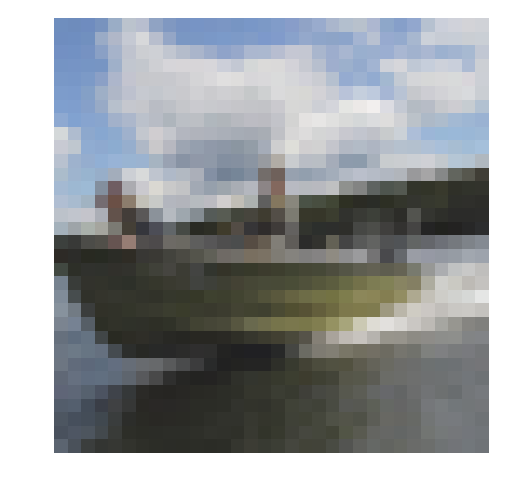

In [5]:
# Explore a specific batch and sample from the dataset
#从数据集中探索特定批次和样本
batch_num = 3
sample_num = 6
batch_image_stats(cifar10_batches_dir_path, batch_num, sample_num)

在继续将数据集输入模型之前，我们需要将其标准化为0到1的范围。
批量标准化优化了网络训练。 它已被证明有几个好处：

更快的训练：由于在网络的前向传递期间的额外计算以及在网络的向后传播过程中训练的额外超参数，每个训练步骤将更慢。 但是，它应该更快地收敛，因此整体训练应该更快。

更高的学习率：梯度下降算法通常需要较小的学习率才能使网络收敛到损失函数的最小值。 随着神经网络越来越深，它们的梯度值在反向传播过程中变得越来越小，因此它们通常需要更多的迭代。 使用批量标准化的想法允许我们使用更高的学习率，这进一步提高了网络训练的速度。

容易初始化权重：权重初始化可能很困难，如果我们使用深度神经网络则会更加困难。 批量标准化似乎让我们在选择初始起始重量时要小心谨慎。

因此，让我们继续定义一个函数，该函数将负责规范输入图像，使这些图像的所有像素值介于0和1之间:

In [6]:
# Normalize CIFAR-10 images to be in the range of [0,1]
#将CIFAR-10图像标准化为[0,1]范围
def normalize_images(images):
    # initial zero ndarray
    normalized_images = np.zeros_like(images.astype(float))

    # The first images index is number of images where the other indices indicates
    #第一图像索引是其他索引指示的图像的数量
    # hieight, width and depth of the image
    #图像的高度，宽度和深度
    num_images = images.shape[0]

    # Computing the minimum and maximum value of the input image to do the normalization based on them
    #计算输入图像的最小值和最大值，以便根据它们进行标准化
    maximum_value, minimum_value = images.max(), images.min()

    # Normalize all the pixel values of the images to be from 0 to 1
    #将图像的所有像素值标准化为0到1
    for img in range(num_images):
        normalized_images[img, ...] = (images[img, ...] - float(minimum_value)) / float(maximum_value - minimum_value)

    return normalized_images

接下来，我们需要实现另一个辅助函数来对输入图像的标签进行编码。在这个函数中，我们将使用sklearn的one-hot编码，其中每个图像标签都由一个0向量表示，除了这个向量表示的图像的类索引之外。
输出向量的大小将取决于我们在数据集中拥有的类的数量，在CIFAR-10数据中是10个类:

In [7]:
# encoding the input images. Each image will be represented by a vector of zeros except for the class index of the image
#编码输入图像。 除了图像的类索引之外，每个图像将由零向量表示
# that this vector represents. The length of this vector depends on number of classes that we have
#这个向量代表。这个向量的长度取决于我们拥有的类的数量
# the dataset which is 10 in CIFAR-10
#CIFAR-10中的数据集为10

def one_hot_encode(images):
    num_classes = 10

    # use sklearn helper function of OneHotEncoder() to do that
    #使用OneHotEncoder（）的sklearn辅助函数来做到这一点
    encoder = OneHotEncoder(num_classes)

    # resize the input images to be 2D
    #将输入图像的大小调整为2D
    input_images_resized_to_2d = np.array(images).reshape(-1, 1)
    one_hot_encoded_targets = encoder.fit_transform(input_images_resized_to_2d)

    return one_hot_encoded_targets.toarray()

现在，是时候调用前面的辅助函数来进行预处理和持久化数据集，以便我们以后可以使用它了:

In [8]:
def preprocess_persist_data(cifar10_batches_dir_path, normalize_images, one_hot_encode):
    num_batches = 5
    valid_input_features = []
    valid_target_labels = []

    for batch_ind in range(1, num_batches + 1):
        # Loading batch
        #加载批次
        input_features, target_labels = load_batch(cifar10_batches_dir_path, batch_ind)
        num_validation_images = int(len(input_features) * 0.1)

        # Preprocess the current batch and perisist it for future use
        #预处理当前批次并对其进行保存以备将来使用
        input_features = normalize_images(input_features[:-num_validation_images])
        target_labels = one_hot_encode(target_labels[:-num_validation_images])

        # Persisting the preprocessed batch
        #保留预处理的批处理
        pickle.dump((input_features, target_labels), open('./preprocess/preprocess_train_batch_' + str(batch_ind) + '.p', 'wb'))

        # Define a subset of the training images to be used for validating our model
        #定义用于验证模型的训练图像的子集
        valid_input_features.extend(input_features[-num_validation_images:])
        valid_target_labels.extend(target_labels[-num_validation_images:])

    # Preprocessing and persisting the validationi subset
    #预处理并持久化validationi子集
    input_features = normalize_images(np.array(valid_input_features))
    target_labels = one_hot_encode(np.array(valid_target_labels))

    pickle.dump((input_features, target_labels), open('./preprocess/preprocess_valid.p', 'wb'))

    # Now it's time to preporcess and persist the test batche
    #现在是时候预处理并持久化测试批次了
    with open(cifar10_batches_dir_path + '/test_batch', mode='rb') as file:
        test_batch = pickle.load(file, encoding='latin1')

    test_input_features = test_batch['data'].reshape((len(test_batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_input_labels = test_batch['labels']

    # Normalizing and encoding the test batch
    #对测试批处理进行规范化和编码
    input_features = normalize_images(np.array(test_input_features))
    target_labels = one_hot_encode(np.array(test_input_labels))

    pickle.dump((input_features, target_labels), open('./preprocess/preprocess_test.p', 'wb'))

# Calling the helper function above to preprocess and persist the training, validation, and testing set
#调用上面的辅助函数来预处理并持久化训练，验证和测试集
preprocess_persist_data(cifar10_batches_dir_path, normalize_images, one_hot_encode)

我们将预处理后的数据保存到磁盘。
我们还需要在训练过程的不同时期加载用于在其上运行训练模型的验证集：

In [9]:
# Load the Preprocessed Validation data
#加载预处理的验证数据
valid_input_features, valid_input_labels = pickle.load(open('./preprocess/preprocess_valid.p', mode='rb'))

# 建立网络

现在是时候构建我们的分类应用程序的核心，这是该CNN架构的计算图，但是为了最大化这种实现的好处，我们不会使用TensorFlow层API。 相反，我们将使用它的TensorFlow神经网络版本。

因此，让我们首先定义模型输入占位符，它将输入图像，目标类和丢失层的保持概率参数（这有助于我们通过删除一些连接来降低架构的复杂性，从而减少机会的可能性过拟合）：

In [10]:
# Defining the model inputs
#定义模型输入
def images_input(img_shape):
    return tf.placeholder(tf.float32, (None,) + img_shape, name="input_images")


def target_input(num_classes):
    target_input = tf.placeholder(tf.int32, (None, num_classes), name="input_images_target")
    return target_input


# define a function for the dropout layer keep probability
#为dropout层定义一个保持概率的函数
def keep_prob_input():
    return tf.placeholder(tf.float32, name="keep_prob")

tf.reset_default_graph()

接下来，我们需要使用TensorFlow神经网络实现版本来构建具有最大池的卷积层：

In [11]:
# Applying a convolution operation to the input tensor followed by max pooling
#将卷积运算应用于输入张量，然后进行最大池化
def conv2d_layer(input_tensor, conv_layer_num_outputs, conv_kernel_size, conv_layer_strides, pool_kernel_size,
                 pool_layer_strides):
    input_depth = input_tensor.get_shape()[3].value
    weight_shape = conv_kernel_size + (input_depth, conv_layer_num_outputs,)

    # Defining layer weights and biases
    #定义图层权重和偏差
    weights = tf.Variable(tf.random_normal(weight_shape))
    biases = tf.Variable(tf.random_normal((conv_layer_num_outputs,)))

    # Considering the biase variable
    #考虑偏差变量
    conv_strides = (1,) + conv_layer_strides + (1,)

    conv_layer = tf.nn.conv2d(input_tensor, weights, strides=conv_strides, padding='SAME')
    conv_layer = tf.nn.bias_add(conv_layer, biases)

    conv_kernel_size = (1,) + conv_kernel_size + (1,)

    pool_strides = (1,) + pool_layer_strides + (1,)

    pool_layer = tf.nn.max_pool(conv_layer, ksize=conv_kernel_size, strides=pool_strides, padding='SAME')

    return pool_layer

正如您在上一章中可能看到的，最大池操作的输出是一个4D张量，它与完全连接层所需的输入格式不兼容。因此，我们需要实现一个平化层，将最大池化层的输出从4D转换为2D张量:

In [12]:
#Flatten the output of max pooling layer to be fing to the fully connected layer which only accepts the output
# to be in 2D
#将最大池层的输出展平为仅接受输出的完全连接层
#在2D中
def flatten_layer(input_tensor):

    return tf.contrib.layers.flatten(input_tensor)

接下来，我们需要定义一个辅助函数，使我们能够在我们的架构中添加一个完全连接的层：

In [13]:
#Define the fully connected layer that will use the flattened output of the stacked convolution layers
#to do the actuall classification
#定义将使用堆叠卷积层的展平输出的完全连接层。
#进行实际分类
def fully_connected_layer(input_tensor, num_outputs):
    return tf.layers.dense(input_tensor, num_outputs)

最后，在使用这些辅助函数创建整个体系结构之前，我们需要创建另一个函数来获取完全连接层的输出，并生成与我们在数据集中具有的类数相对应的10个实值：

In [14]:
#Defining the output function
#定义输出函数
def output_layer(input_tensor, num_outputs):
    return  tf.layers.dense(input_tensor, num_outputs)

所以，让我们继续并定义将所有这些碎片组合在一起并创建具有三个卷积层的CNN的功能。 其中每一个都遵循最大池操作。 我们还将有两个完全连接的层，其中每个层后面都有一个压差层，以降低模型复杂性并防止过度拟合。 最后，我们将使输出层生成10个实值向量，其中每个值表示每个类的得分是正确的：

In [15]:
def build_convolution_net(image_data, keep_prob):
    # Applying 3 convolution layers followed by max pooling layers
    #应用3个卷积层，然后应用最大池化层
    conv_layer_1 = conv2d_layer(image_data, 32, (3, 3), (1, 1), (3, 3), (3, 3))
    conv_layer_2 = conv2d_layer(conv_layer_1, 64, (3, 3), (1, 1), (3, 3), (3, 3))
    conv_layer_3 = conv2d_layer(conv_layer_2, 128, (3, 3), (1, 1), (3, 3), (3, 3))

    # Flatten the output from 4D to 2D to be fed to the fully connected layer
    #将输出从4D展平为2D以馈送到完全连接的层
    flatten_output = flatten_layer(conv_layer_3)

    # Applying 2 fully connected layers with drop out
    #应用2个完全连接的层并退出
    fully_connected_layer_1 = fully_connected_layer(flatten_output, 64)
    fully_connected_layer_1 = tf.nn.dropout(fully_connected_layer_1, keep_prob)
    fully_connected_layer_2 = fully_connected_layer(fully_connected_layer_1, 32)
    fully_connected_layer_2 = tf.nn.dropout(fully_connected_layer_2, keep_prob)

    # Applying the output layer while the output size will be the number of categories that we have
    # in CIFAR-10 dataset
    #应用输出层，而输出大小将是我们拥有的类别数。 在CIFAR-10数据集中
    output_logits = output_layer(fully_connected_layer_2, 10)

    # returning output
    #返回输出
    return output_logits


让我们调用前面的辅助函数来构建网络并定义其丢失和优化标准：

In [16]:
#Using the helper function above to build the network
#使用上面的辅助函数来构建网络
#First off, let's remove all the previous inputs, weights, biases form the previous runs
#首先，让我们删除之前运行的所有先前的输入，权重和偏差
tf.reset_default_graph()

# Defining the input placeholders to the convolution neural network
#将输入占位符定义到卷积神经网络
input_images = images_input((32, 32, 3))
input_images_target = target_input(10)
keep_prob = keep_prob_input()

# Building the models
#建立模型
logits_values = build_convolution_net(input_images, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
#名称logits Tensor，因此可以在训练后从磁盘加载
logits_values = tf.identity(logits_values, name='logits')

# defining the model loss
#定义模型损失
model_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_values, labels=input_images_target))

# Defining the model optimizer
#定义模型优化器
model_optimizer = tf.train.AdamOptimizer().minimize(model_cost)

# Calculating and averaging the model accuracy
#计算和平均模型精度
correct_prediction = tf.equal(tf.argmax(logits_values, 1), tf.argmax(input_images_target, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='model_accuracy')
#tests.test_conv_net(build_convolution_net)这行代码书上有代码里面没有

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



现在我们已经建立了这个网络的计算架构，现在是时候开始培训过程并看到一些结果。

# 模型训练

因此，让我们定义一个辅助函数，使我们能够启动训练过程。该函数将获取输入图像、目标类的one-hot编码，并保留概率值作为输入。然后，它将把这些值提供给计算图，并调用模型优化器:

In [17]:
#Define a helper function for kicking off the training process
#定义辅助函数以启动培训过程
def train(session, model_optimizer, keep_probability, in_feature_batch, target_batch):

    session.run(model_optimizer, feed_dict={input_images: in_feature_batch, input_images_target: target_batch, keep_prob: keep_probability})

我们需要在训练过程的不同时间步骤中验证我们的模型，因此我们将定义一个辅助函数，该函数将在验证集上打印出模型的准确性：

In [18]:
# Defining a helper funcitno for print information about the model accuracy and it's validation accuracy as well
#定义辅助函数以获取有关模型精度的打印信息以及它的验证准确性
def print_model_stats(session, input_feature_batch, target_label_batch, model_cost, model_accuracy):
    validation_loss = session.run(model_cost,
                                  feed_dict={input_images: input_feature_batch, input_images_target: target_label_batch,
                                             keep_prob: 1.0})
    validation_accuracy = session.run(model_accuracy, feed_dict={input_images: input_feature_batch,
                                                                 input_images_target: target_label_batch,
                                                                 keep_prob: 1.0})

    print("Valid Loss: %f" % (validation_loss))
    print("Valid accuracy: %f" % (validation_accuracy))

我们还定义模型超参数，我们可以使用它来调整模型以获得更好的性能：

In [19]:
# Model Hyperparameters
#模型超参数
# 原始数据num_epochs是100，batch_size是128
num_epochs = 100
batch_size = 128
keep_probability = 0.5

现在，让我们开始训练过程，但仅针对一批CIFAR-10数据集，并查看基于此批次的模型准确性。

然而，在此之前，我们将定义一个辅助函数，它将加载批处理训练并将输入图像与目标类分开：

In [20]:
# Splitting the dataset features and labels to batches
#将数据集特征和标签拆分为批次
def batch_split_features_labels(input_features, target_labels, train_batch_size):
    for start in range(0, len(input_features), train_batch_size):
        end = min(start + train_batch_size, len(input_features))
        yield input_features[start:end], target_labels[start:end]

#Loading the persisted preprocessed training batches
#加载持久的预处理培训批次
def load_preprocess_training_batch(batch_id, batch_size):
    filename = './preprocess/preprocess_train_batch_' + str(batch_id) + '.p'
    input_features, target_labels = pickle.load(open(filename, mode='rb'))
    train_batch_size = batch_size

    # Returning the training images in batches according to the batch size defined above
    #根据上面定义的批量大小分批返回训练图像
    return batch_split_features_labels(input_features, target_labels, train_batch_size)

现在，让我们开始一批的训练过程：

In [21]:
print('Training on only a Single Batch from the CIFAR-10 Dataset...')

with tf.Session() as sess:
    # Initializing the variables
    # 初始化变量
    sess.run(tf.global_variables_initializer())

    # Training cycle
    # 训练周期
    for epoch in range(num_epochs):
        batch_ind = 1

        for batch_features, batch_labels in load_preprocess_training_batch(batch_ind, batch_size):
            train(sess, model_optimizer, keep_probability, batch_features, batch_labels)

        print('Epoch number {:>2}, CIFAR-10 Batch Number {}:  '.format(epoch + 1, batch_ind), end='')
        print_model_stats(sess, batch_features, batch_labels, model_cost, accuracy)

Training on only a Single Batch from the CIFAR-10 Dataset...
Epoch number  1, CIFAR-10 Batch Number 1:  Valid Loss: 293.963135
Valid accuracy: 0.200000
Epoch number  2, CIFAR-10 Batch Number 1:  Valid Loss: 153.959122
Valid accuracy: 0.375000
Epoch number  3, CIFAR-10 Batch Number 1:  Valid Loss: 117.611549
Valid accuracy: 0.450000
Epoch number  4, CIFAR-10 Batch Number 1:  Valid Loss: 96.232826
Valid accuracy: 0.325000
Epoch number  5, CIFAR-10 Batch Number 1:  Valid Loss: 64.179176
Valid accuracy: 0.450000
Epoch number  6, CIFAR-10 Batch Number 1:  Valid Loss: 47.152710
Valid accuracy: 0.400000
Epoch number  7, CIFAR-10 Batch Number 1:  Valid Loss: 38.405567
Valid accuracy: 0.550000
Epoch number  8, CIFAR-10 Batch Number 1:  Valid Loss: 31.021799
Valid accuracy: 0.375000
Epoch number  9, CIFAR-10 Batch Number 1:  Valid Loss: 25.224461
Valid accuracy: 0.450000
Epoch number 10, CIFAR-10 Batch Number 1:  Valid Loss: 21.938726
Valid accuracy: 0.450000
Epoch number 11, CIFAR-10 Batch Numb

如您所见，仅在单个批次上进行培训时，验证准确性并不高。 让我们看看验证准确性如何仅根据模型的完整培训流程进行更改：

In [22]:
print('Full training for the network...')  
model_save_path = './classification/cifar-10_classification'

with tf.Session() as sess:
    # Initializing the variables
    # 初始化变量
    sess.run(tf.global_variables_initializer())

    # Training cycle
    # 训练周期
    for epoch in range(num_epochs):

        # iterate through the batches
        # 遍历批次
        num_batches = 5

        for batch_ind in range(1, num_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_ind, batch_size):
                train(sess, model_optimizer, keep_probability, batch_features, batch_labels)

            print('Epoch number{:>2}, CIFAR-10 Batch Number {}:  '.format(epoch + 1, batch_ind), end='')
            print_model_stats(sess, batch_features, batch_labels, model_cost, accuracy)

    # Save the trained Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, model_save_path)

Full training for the network...
Epoch number 1, CIFAR-10 Batch Number 1:  Valid Loss: 409.357758
Valid accuracy: 0.225000
Epoch number 1, CIFAR-10 Batch Number 2:  Valid Loss: 271.498352
Valid accuracy: 0.300000
Epoch number 1, CIFAR-10 Batch Number 3:  Valid Loss: 121.103394
Valid accuracy: 0.425000
Epoch number 1, CIFAR-10 Batch Number 4:  Valid Loss: 101.355110
Valid accuracy: 0.350000
Epoch number 1, CIFAR-10 Batch Number 5:  Valid Loss: 81.377403
Valid accuracy: 0.325000
Epoch number 2, CIFAR-10 Batch Number 1:  Valid Loss: 81.818733
Valid accuracy: 0.375000
Epoch number 2, CIFAR-10 Batch Number 2:  Valid Loss: 64.170433
Valid accuracy: 0.400000
Epoch number 2, CIFAR-10 Batch Number 3:  Valid Loss: 27.400745
Valid accuracy: 0.500000
Epoch number 2, CIFAR-10 Batch Number 4:  Valid Loss: 29.049261
Valid accuracy: 0.475000
Epoch number 2, CIFAR-10 Batch Number 5:  Valid Loss: 25.695215
Valid accuracy: 0.400000
Epoch number 3, CIFAR-10 Batch Number 1:  Valid Loss: 24.224697
Valid acc

Epoch number38, CIFAR-10 Batch Number 1:  Valid Loss: 1.086018
Valid accuracy: 0.575000
Epoch number38, CIFAR-10 Batch Number 2:  Valid Loss: 1.248665
Valid accuracy: 0.575000
Epoch number38, CIFAR-10 Batch Number 3:  Valid Loss: 0.979255
Valid accuracy: 0.700000
Epoch number38, CIFAR-10 Batch Number 4:  Valid Loss: 1.051253
Valid accuracy: 0.700000
Epoch number38, CIFAR-10 Batch Number 5:  Valid Loss: 1.163857
Valid accuracy: 0.575000
Epoch number39, CIFAR-10 Batch Number 1:  Valid Loss: 1.111699
Valid accuracy: 0.575000
Epoch number39, CIFAR-10 Batch Number 2:  Valid Loss: 1.211628
Valid accuracy: 0.525000
Epoch number39, CIFAR-10 Batch Number 3:  Valid Loss: 0.945881
Valid accuracy: 0.650000
Epoch number39, CIFAR-10 Batch Number 4:  Valid Loss: 1.112708
Valid accuracy: 0.600000
Epoch number39, CIFAR-10 Batch Number 5:  Valid Loss: 1.059367
Valid accuracy: 0.650000
Epoch number40, CIFAR-10 Batch Number 1:  Valid Loss: 1.052228
Valid accuracy: 0.650000
Epoch number40, CIFAR-10 Batch N

Epoch number75, CIFAR-10 Batch Number 2:  Valid Loss: 0.401530
Valid accuracy: 0.875000
Epoch number75, CIFAR-10 Batch Number 3:  Valid Loss: 0.353528
Valid accuracy: 0.900000
Epoch number75, CIFAR-10 Batch Number 4:  Valid Loss: 0.485423
Valid accuracy: 0.850000
Epoch number75, CIFAR-10 Batch Number 5:  Valid Loss: 0.399531
Valid accuracy: 0.900000
Epoch number76, CIFAR-10 Batch Number 1:  Valid Loss: 0.421074
Valid accuracy: 0.900000
Epoch number76, CIFAR-10 Batch Number 2:  Valid Loss: 0.447072
Valid accuracy: 0.825000
Epoch number76, CIFAR-10 Batch Number 3:  Valid Loss: 0.363383
Valid accuracy: 0.900000
Epoch number76, CIFAR-10 Batch Number 4:  Valid Loss: 0.470939
Valid accuracy: 0.825000
Epoch number76, CIFAR-10 Batch Number 5:  Valid Loss: 0.409506
Valid accuracy: 0.850000
Epoch number77, CIFAR-10 Batch Number 1:  Valid Loss: 0.395905
Valid accuracy: 0.850000
Epoch number77, CIFAR-10 Batch Number 2:  Valid Loss: 0.422292
Valid accuracy: 0.875000
Epoch number77, CIFAR-10 Batch N

# 测试模型

让我们根据CIFAR-10数据集的测试集部分测试训练的模型。 首先，我们将定义一个辅助函数，它将帮助我们可视化一些示例图像及其相应的真实标签的预测：

In [23]:
# A helper function to visualize some samples and their corresponding predictions
# 辅助函数可视化一些样本及其相应的预测
def display_samples_predictions(input_features, target_labels, samples_predictions):
    num_classes = 10

    cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(num_classes))
    label_inds = label_binarizer.inverse_transform(np.array(target_labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    num_predictions = 4
    margin = 0.05
    ind = np.arange(num_predictions)
    width = (1. - 2. * margin) / num_predictions

    for image_ind, (feature, label_ind, prediction_indicies, prediction_values) in enumerate(
            zip(input_features, label_inds, samples_predictions.indices, samples_predictions.values)):
        prediction_names = [cifar10_class_names[pred_i] for pred_i in prediction_indicies]
        correct_name = cifar10_class_names[label_ind]

        axies[image_ind][0].imshow(feature)
        axies[image_ind][0].set_title(correct_name)
        axies[image_ind][0].set_axis_off()

        axies[image_ind][1].barh(ind + margin, prediction_values[::-1], width)
        axies[image_ind][1].set_yticks(ind + margin)
        axies[image_ind][1].set_yticklabels(prediction_names[::-1])
        axies[image_ind][1].set_xticks([0, 0.5, 1.0])

现在，让我们恢复训练好的模型并根据测试集进行测试：

INFO:tensorflow:Restoring parameters from ./classification/cifar-10_classification
Test set accuracy: 0.6189291401273885



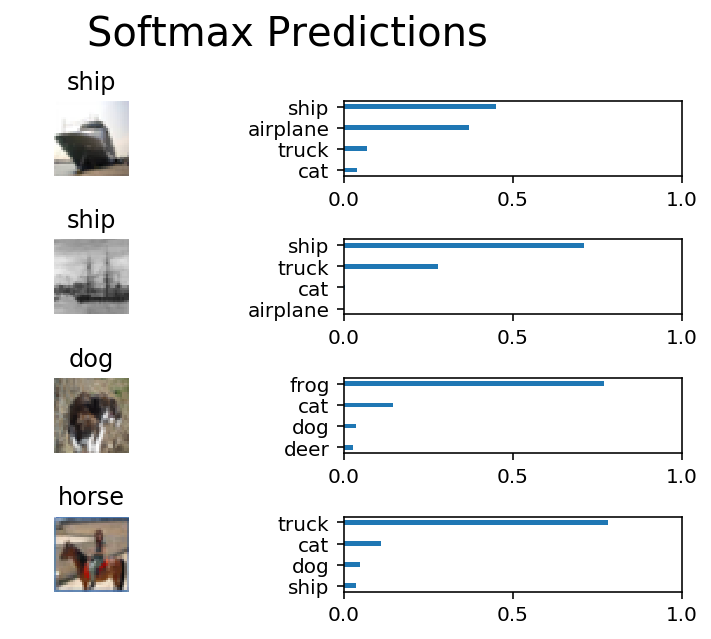

In [24]:
test_batch_size = 64

save_model_path = './classification/cifar-10_classification'

# Number of images to visualize
# 要可视化的图像数量
num_samples = 4

# Number of top predictions
# 最高预测数量
top_n_predictions = 4

# Defining a helper function for testing the trained model
# 定义辅助函数以测试训练模型
def test_classification_model():
    input_test_features, target_test_labels = pickle.load(open('./preprocess/preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # loading the trained model
        # 加载训练的模型
        model = tf.train.import_meta_graph(save_model_path + '.meta')
        model.restore(sess, save_model_path)

        # Getting some input and output Tensors from loaded model
        # 从加载的模型中获取一些输入和输出张量
        model_input_values = loaded_graph.get_tensor_by_name('input_images:0')
        model_target = loaded_graph.get_tensor_by_name('input_images_target:0')
        model_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        model_logits = loaded_graph.get_tensor_by_name('logits:0')
        model_accuracy = loaded_graph.get_tensor_by_name('model_accuracy:0')

        # Testing the trained model on the test set batches
        # 在测试集批次上测试训练的模型
        test_batch_accuracy_total = 0
        test_batch_count = 0

        for input_test_feature_batch, input_test_label_batch in batch_split_features_labels(input_test_features,
                                                                                            target_test_labels,
                                                                                            test_batch_size):
            test_batch_accuracy_total += sess.run(
                model_accuracy,
                feed_dict={model_input_values: input_test_feature_batch, model_target: input_test_label_batch,
                           model_keep_prob: 1.0})
            test_batch_count += 1

        print('Test set accuracy: {}\n'.format(test_batch_accuracy_total / test_batch_count))

        # print some random images and their corresponding predictions from the test set results
        #从测试集结果中打印一些随机图像及其相应的预测
        random_input_test_features, random_test_target_labels = tuple(
            zip(*random.sample(list(zip(input_test_features, target_test_labels)), num_samples)))

        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(model_logits), top_n_predictions),
            feed_dict={model_input_values: random_input_test_features, model_target: random_test_target_labels,
                       model_keep_prob: 1.0})

        display_samples_predictions(random_input_test_features, random_test_target_labels, random_test_predictions)

# Calling the function
# 调用函数
test_classification_model()

现在，我们的测试精度大约为62％，对于像我们使用的CNN这样简单的CNN也不错。

# 总结

本章向我们展示了如何制作CNN来对CIFAR-10数据集中的图像进行分类。 测试集的分类准确度约为79％-80％。 还绘制了卷积层的输出，但很难看出神经网络如何识别和分类输入图像。 需要更好的可视化技术。

接下来，我们将使用现代和令人兴奋的深度学习实践之一，即转移学习。 转移学习允许您使用数据贪婪的小型数据集深度学习架构。